In [125]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import itertools

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from scipy.sparse.linalg import norm, svds
from scipy.sparse import csr_matrix, find

%matplotlib inline
import matplotlib.pyplot as plt

from df_builder_mini_cleaner import *
from word_counts import *




# Creating the DataFrame

In [2]:
cnn_df = pd.read_csv('data/cnn.csv')
fox_df = pd.read_csv('data/fox.csv')
onion_df = pd.read_csv('data/onion_csv.csv')

In [70]:
half = cnn_df[0:5000]

In [72]:
half.year.unique()

array([2016., 2017., 2013., 2012., 2014., 2015.])

In [3]:
df_final = build_df(onion_df, fox_df, cnn_df)

In [4]:
df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general’s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pet’s alle...,1,0,0


# Word Count

In [5]:
onion_word_count = word_count(list(df_final.Article[0:4927]))

In [6]:
cnn_word_count = word_count(list(df_final.Article[4927:9927]))

In [7]:
fox_word_count = word_count(list(df_final.Article[9927:]))

In [8]:
word_counts_df = pd.DataFrame([['Onion', onion_word_count], ['CNN', cnn_word_count], ['Fox', fox_word_count]], columns=['Source', 'Average_Word_Count'])

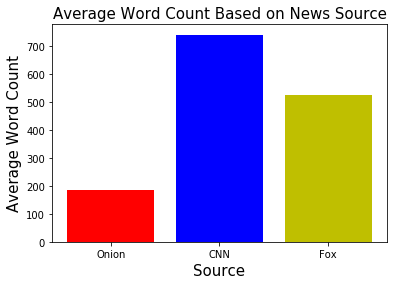

In [9]:
word_count_graph(word_counts_df)

### More Cleaning

In [397]:
def new_cleaner(df):
    '''
    Removes more features like punctuation and words that
    should not be in there
    Input: df_final
    output: df_final with cleaned articles
    '''
    article_list = list(df_final.Article)
    clean_list = []
    for article in article_list:
        # regex not a-z or whitespace
        #samp1 = re.sub('[''\”\“\‘;:\'\'\'•·%$!&+}{|><_…/\’*0123456789\`]', '', article)
        #samp2 = re.sub('[-—]', ' ', samp1)
        samp1 = re.sub(r'\W+', ' ', article)
        samp2 = re.sub('[0123456789]', '', samp1)
        
        samp3 = samp2.replace('news','')
        clean_list.append(samp3.replace('fox',''))
    df['Article'] = clean_list
    return df

In [398]:
new_df_final = new_cleaner(df_final)

In [399]:
new_df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney generals br...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pets alleg...,1,0,0


# Models

### Tokenizing and Stemming

In [13]:
def tokenize(doc):
    return [porter.stem(word) for word in word_tokenize(doc)]

In [304]:
test_stop_words = ['serious','any', 'ours', 'go', 'do', 'else', 'while', 'somehow', 'seem', 'front', 'thick', 'once', 'system',
 'latter', 'amongst', 'hence', 'un', 'cannot', 'more', 'eight', 'he', 'seems', 'it', 'hereafter', 'last', 'here',
 'beyond', 'because', 'few', 'fill', 'his', 'further', 'sincere', 'their', 'made', 'fifty', 'whatever', 'whenever', 'been', 'describe', 'otherwise',
 'or', 'our', 'move', 'eg', 'over', 'per', 'amoungst', 'perhaps', 'you', 'beside', 'hundred', 'across',
 'which', 'where', 'anyone', 'anywhere', 'name', 'several', 'a', 'no', 'whence', 'mostly', 'so', 'call',
 'seemed', 'everyone', 'these', 'besides', 'whom', 'whereby', 'eleven', 'thereupon', 'twelve', 'when', 'former', 'most',
 'therein', 'had', 'hasnt', 'yourself', 'next', 'being', 'wherein', 'only', 'them', 'third', 'mine', 'show',
 'nobody', 'sometimes', 'somewhere', 'still', 'were', 'with', 'became', 'how', 'yourselves', 'her', 'much',
 'ltd', 'as', 'those', 'done', 'twenty', 'along', 'get', 'herself', 'interest', 'nor', 'however', 'same', 'side', 'whole', 'namely', 'might',
 'if', 'has', 'up', 'both', 'not', 'bottom', 'ourselves', 'via', 'whither', 'fifteen', 'your', 'mill',
 'someone', 'even', 'please', 'thus', 'under', 'are', 'in', 'etc', 'anyhow', 'after', 'hereupon', 'my', 'from',
 'through', 'before', 'own', 'against', 'below', 'throughout', 'although', 'herein', 'himself', 'noone', 'will',
 'also', 'thru', 'out', 'keep', 'something', 'there', 'nevertheless', 'nine', 'always', 'except', 'almost', 'some',
 'couldnt', 'hereby', 'indeed', 'detail', 'moreover', 'hers', 're', 'all', 'six', 'themselves', 'two', 'already', 'forty',
 'thereby', 'become', 'each', 'thence', 'within', 'nowhere', 'by', 'due', 'full', 'thin', 'us', 'anyway', 'other', 'among', 'this',
 'though', 'without', 'then', 'five', 'another', 'first', 'myself', 'every', 'at', 'de', 'toward', 'whereafter',
 'alone', 'beforehand', 'amount', 'ie', 'meanwhile', 'behind', 'must', 'now', 'others', 'many', 'be', 'con', 'an', 'formerly',
 'everywhere', 'therefore', 'find', 'to', 'together', 'could', 'elsewhere', 'about', 'three', 'am', 'since', 'me',
 'whose', 'ever', 'cry', 'becoming', 'whereas', 'see', 'well', 'back', 'everything', 'nothing', 'whether', 'itself', 'whoever', 'often', 'never', 'down', 'top', 'least', 'too',
 'of', 'during', 'inc', 'less', 'that', 'she', 'give', 'than', 'latterly', 'they', 'fire', 'found', 'the',
 'bill', 'thereafter', 'enough', 'very', 'have', 'its', 'who', 'anything', 'afterwards', 'around', 'upon',
 'but', 'either', 'again', 'should', 'what', 'into', 'none', 'would', 'can', 'for', 'put', 'empty', 'why', 'is', 'him', 'above', 'between', 'four', 'off',
 'cant', 'may', 'sometime', 'until', 'and', 'part', 'yet', 'onto', 'towards', 'neither', 'yours',
 'we', 'take', 'rather', 'on', 'such', 'was', 'ten', 'becomes', 'co', 'one', 'i', 'seeming', 'wherever', 'whereupon', 'sixty', 'trump', 'clinton']

### Train Test Split

In [400]:
docs_train, docs_test, y_train, y_test = train_test_split(new_df_final['Article'], new_df_final['Satire'])

In [401]:
def tokenize2(doc):
    '''
    Tokenization function for the TFIDF vectorizor
    input: string of article
    output: list of article tokens that have been stemmed
    '''
    # Tokenizes each word in the document
    tokens = word_tokenize(doc)
    # Defines an empty list to append the stemmed words to
    cleaned_docs = []
    # Creates PorterStemmer object
    porter = PorterStemmer()
    # For loop to iterate through tokens in document
    for word in tokens:
    # Removes tokens that are just one character
        if len(word) < 2:
            tokens.remove(word)
    # Removes stop words from articles that are in test_stop_words 
    # list and appends porter stemmed words to the cleaned doc list
        else:
            if word not in test_stop_words:
                stem_word = porter.stem(word)
                if stem_word not in test_stop_words:
                    cleaned_docs.append(stem_word)
    # Returns list of tokens
    return cleaned_docs
    

### TFIDF Vectorization 

In [402]:
# cust_stop_words = ['serious', 'any', 'ours', 'go', 'do','else', 'while', 'somehow', 'seem', 'front', 'thick', 'once', 'system', 'latter', 'amongst', 'hence', 'un',
#  'cannot', 'more', 'eight', 'he', 'seems', 'it', 'hereafter', 'last', 'here', 'beyond', 'because', 'few', 'fill',
#  'his', 'further', 'sincere', 'their', 'made', 'fifty', 'whatever', 'whenever', 'been', 'describe', 'otherwise', 'or',
#  'our', 'move', 'eg', 'over', 'per', 'amoungst', 'perhaps', 'you', 'beside', 'hundred', 'across', 'which',
#  'where', 'anyone', 'anywhere', 'name', 'several', 'a', 'no', 'whence', 'mostly', 'so', 'call', 'seemed', 'everyone',
#  'these', 'besides', 'whom', 'whereby', 'eleven', 'thereupon', 'twelve', 'when', 'former', 'most', 'therein', 'had',
#  'hasnt', 'yourself', 'next', 'being', 'wherein', 'only', 'them', 'third', 'mine', 'show', 'nobody',
#  'sometimes', 'somewhere', 'still', 'were', 'with', 'became', 'how', 'yourselves', 'her', 'much', 'ltd', 'as', 'those',
#  'done', 'twenty', 'along', 'get', 'herself', 'interest', 'nor', 'however', 'same', 'side', 'whole', 'namely',
#  'might', 'if', 'has', 'up', 'both', 'not', 'bottom', 'ourselves', 'via', 'whither', 'fifteen', 'your', 'mill', 'someone', 'even',
#  'please', 'thus', 'under', 'are', 'in', 'etc', 'anyhow', 'after', 'hereupon', 'my', 'from', 'through', 'before', 'own', 'against', 'below', 'throughout', 'although', 'herein',
#  'himself', 'noone', 'will', 'also', 'thru', 'out', 'keep', 'something', 'there', 'nevertheless', 'nine', 'always',
#  'except', 'almost', 'some', 'couldnt', 'hereby', 'indeed', 'detail', 'moreover', 'hers', 're', 'all', 'six',
#  'themselves', 'two', 'already', 'forty', 'thereby', 'become', 'each', 'thence', 'within', 'nowhere', 'by', 'due', 'full', 'thin', 'us', 'anyway', 'other', 'among', 'this', 'though', 'without', 'then', 'five', 'another', 'first', 'myself', 'every', 'at', 'de', 'toward',
# 'whereafter', 'alone', 'beforehand', 'amount', 'ie', 'meanwhile', 'behind', 'must', 'now', 'others',
#  'many', 'be', 'con', 'an', 'formerly', 'everywhere', 'therefore', 'find', 'to', 'together', 'could', 'elsewhere', 'about', 'three', 'am', 'since', 'me', 'whose', 'ever', 'cry', 'becoming', 'whereas', 'see', 'well', 'back', 'everything', 'nothing', 'whether', 'itself',
#  'whoever', 'often', 'never', 'down', 'top', 'least', 'too', 'of', 'during', 'inc', 'less', 'that', 'she', 'give', 'than',
#  'latterly', 'they', 'fire', 'found', 'the', 'bill', 'thereafter', 'enough', 'very', 'have', 'its', 'who', 'anything',
#  'afterwards', 'around', 'upon', 'but', 'either', 'again', 'should', 'what', 'into', 'none', 'would', 'can', 'for', 'put', 'empty', 'why', 'is', 'him',
#  'above', 'between', 'four', 'off', 'cant', 'may', 'sometime', 'until', 'and', 'part', 'yet', 'onto', 'towards','neither',
#  'yours', 'we', 'take', 'rather', 'on', 'such', 'was', 'ten', 'becomes', 'co', 'one', 'i', 'seeming', 'wherever','whereupon','sixty','abov', 'afterward', 
# 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els',
# 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr',
# 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 
# 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth',
# 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 
# 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv','anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh','ad']

In [ ]:
vect = TfidfVectorizer(tokenizer=tokenize2, min_df=3, max_df=.95)
# tune min_df and use max_df
X_train = vect.fit_transform(docs_train)
X_test = vect.transform(docs_test)

### Logistic Regression Model

In [308]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [309]:
log_reg_y_pred = log_reg.predict(X_test)
log_reg_con_mat = confusion_matrix(y_test, log_reg_y_pred)
recall_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[1,0])
prec_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[0,1])
F1_log_reg = ((prec_log_reg*recall_log_reg)/(prec_log_reg+recall_log_reg))*2
print('F1 = {}, Precision = {}, Recall = {}'.format(F1_log_reg, prec_log_reg, recall_log_reg))

F1 = 0.9746478873239437, Precision = 0.9805668016194332, Recall = 0.9688


### Naive Bayes Model

In [310]:
#grid search for alpha

na_ba_1 = MultinomialNB(alpha=1)
na_ba_1.fit(X_train, y_train)

na_ba = MultinomialNB(alpha=.1)
na_ba.fit(X_train, y_train)

na_ba_0 = MultinomialNB(alpha=.0001)
na_ba_0.fit(X_train, y_train)


MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

#### Naive Bayes alpha = 1

In [311]:
na_ba_1_pred = na_ba_1.predict(X_test)
na_ba_1_con_mat = confusion_matrix(y_test, na_ba_1_pred)
recall_na_ba_1= na_ba_1_con_mat[1,1]/(na_ba_1_con_mat[1,1]+na_ba_1_con_mat[1,0])
prec_na_ba_1 = na_ba_1_con_mat[1,1]/(na_ba_1_con_mat[1,1]+na_ba_1_con_mat[0,1])
F1_na_ba_1 = ((prec_na_ba_1*recall_na_ba_1)/(prec_na_ba_1+recall_na_ba_1))*2
print('F1 = {}, Precision = {}, Recall = {}'.format(F1_na_ba_1, prec_na_ba_1, recall_na_ba_1))




F1 = 0.830393487109905, Precision = 0.9552549427679501, Recall = 0.7344


#### Naive Bayes alpha = .1

In [312]:
na_ba_pred = na_ba.predict(X_test)
na_ba_con_mat = confusion_matrix(y_test, na_ba_pred)
recall_na_ba= na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[1,0])
prec_na_ba = na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[0,1])
F1_na_ba = ((prec_na_ba*recall_na_ba)/(prec_na_ba+recall_na_ba))*2
print('F1 = {}, Precision = {}, Recall = {}'.format(F1_na_ba, prec_na_ba, recall_na_ba))

F1 = 0.8845995893223818, Precision = 0.9088607594936708, Recall = 0.8616


#### Naive Bayes alpha = .0001

In [313]:
na_ba_0_pred = na_ba_0.predict(X_test)
na_ba_0_con_mat = confusion_matrix(y_test, na_ba_0_pred)
recall_na_ba_0= na_ba_0_con_mat[1,1]/(na_ba_0_con_mat[1,1]+na_ba_0_con_mat[1,0])
prec_na_ba_0 = na_ba_0_con_mat[1,1]/(na_ba_0_con_mat[1,1]+na_ba_0_con_mat[0,1])
F1_na_ba_0 = ((prec_na_ba_0*recall_na_ba_0)/(prec_na_ba_0+recall_na_ba_0))*2
print('F1 = {}, Precision = {}, Recall = {}'.format(F1_na_ba_0, prec_na_ba_0, recall_na_ba_0))

F1 = 0.868169991326973, Precision = 0.9479166666666666, Recall = 0.8008


# Data Vis for Models

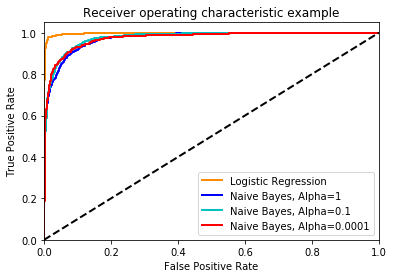

In [314]:
roc_log_reg  = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1], pos_label=1)

roc_na_ba_1  = roc_curve(y_test, na_ba_1.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba  = roc_curve(y_test, na_ba.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba_0  = roc_curve(y_test, na_ba_0.predict_proba(X_test)[:,1], pos_label=1)


plt.figure()
lw = 2
plt.plot(roc_log_reg[0], roc_log_reg[1], color='darkorange',
         lw=lw, label='Logistic Regression')

plt.plot(roc_na_ba_1[0], roc_na_ba_1[1], color='b',
         lw=lw, label='Naive Bayes, Alpha=1')
plt.plot(roc_na_ba[0], roc_na_ba[1], color='c',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot(roc_na_ba_0[0], roc_na_ba_0[1], color='r',
         lw=lw, label='Naive Bayes, Alpha=0.0001')


plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [315]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[2281   24]
 [  39 1211]]


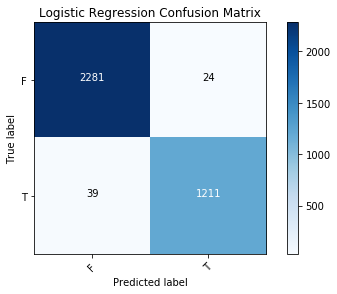

In [316]:
plot_confusion_matrix(log_reg_con_mat,['F','T'], title='Logistic Regression Confusion Matrix')

Confusion matrix
[[2262   43]
 [ 332  918]]


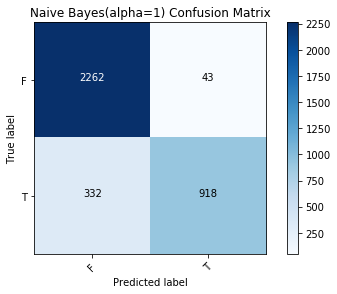

In [317]:
plot_confusion_matrix(na_ba_1_con_mat,['F','T'], title='Naive Bayes(alpha=1) Confusion Matrix')

Confusion matrix
[[2197  108]
 [ 173 1077]]


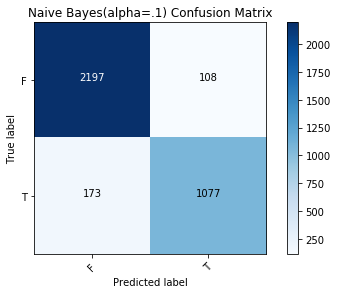

In [318]:
plot_confusion_matrix(na_ba_con_mat,['F','T'], title='Naive Bayes(alpha=.1) Confusion Matrix')

Confusion matrix
[[2250   55]
 [ 249 1001]]


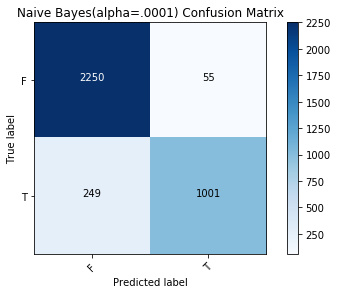

In [319]:
plot_confusion_matrix(na_ba_0_con_mat,['F','T'], title='Naive Bayes(alpha=.0001) Confusion Matrix')

# Feature Exploration

In [320]:
features = vect.get_feature_names()

log_reg_coef = log_reg.coef_.reshape(log_reg.coef_.shape[1],)

In [321]:
log_reg.coef_.shape[1]

19822

In [322]:
len(features), len(log_reg_coef)

(19822, 19822)

In [323]:
feature_df = pd.DataFrame(features)

In [324]:
feature_df

,0
0,''
1,``
2,aa
3,aaa
4,aamaq
5,aaron
6,aarp
7,ab
8,abaaoud
9,aback


In [325]:
feature_df['Beta_Coef'] = log_reg_coef
feature_df['Word'] = feature_df[0]

In [326]:
beta_feature_df = feature_df[['Beta_Coef', 'Word']]

In [327]:
sort = beta_feature_df.sort_values('Beta_Coef')

In [328]:
sort

,Beta_Coef,Word
15182,-6.667541,said
17794,-4.390837,told
122,-4.128365,accord
13409,-3.945401,polic
8620,-3.168069,includ
1056,-2.997107,attack
18167,-2.978889,twitter
15322,-2.921398,saturday
15345,-2.787467,say
14609,-2.765636,republican


In [329]:
bot_10=list(sort['Beta_Coef'][0:10])
top_10=list(sort['Beta_Coef'][-10:])
bot_top = bot_10 +top_10

In [330]:
bot_10_words = list(sort['Word'][0:10])
top_10_words = list(sort['Word'][-10:])
top_bot_words = bot_10_words + top_10_words

Text(0.5, 0, 'Word')

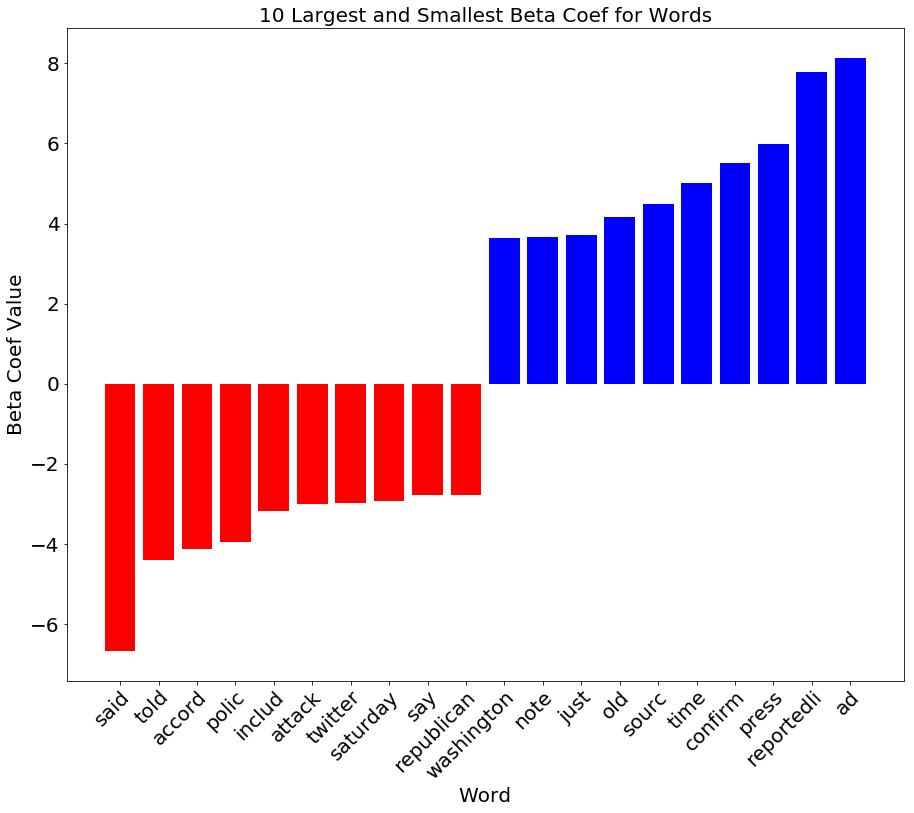

In [331]:
data = bot_top
labels = top_bot_words
fig, ax = plt.subplots(figsize=(15,12))

plt.bar(np.arange(len(data)), data, color = 'rrrrrrrrrrbbbbbbbbbb')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, fontsize =20, ha='right', rotation_mode='anchor')
plt.setp( ax.yaxis.get_majorticklabels(), fontsize = 20)
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words", fontsize = 20)
ax.set_ylabel("Beta Coef Value", fontsize = 20)
ax.set_xlabel("Word", fontsize = 20)

Word count on add and different variations of ad. Fix time of articles. Remove words like trump and clinton

With out stemming adding is one of the most important words, so left ad in there

### Average Magnitude of TFIDF Vector for Satire and News

In [173]:
def avg_tfidf_mag(X_train_vect, y_train):
    '''
    Calculates the average magnitude of the TFIDF vector for Satire and News 
    categories
    input: sparse matrix for training
    '''
    row_norms=[]
    for row in X_train:
        row_norms.append(norm(row))
    sums_arr =np.array(row_norms)
    ytr_arr = np.array(y_train)
    tot_sat_art = np.sum(ytr_arr)
    tot_news_art = len(ytr_arr) - tot_sat_art
    Sat_avg_mag = sums_arr[ytr_arr==1].sum()/tot_sat_art
    News_avg_mag = sums_arr[ytr_arr==0].sum()/tot_news_art
    return Sat_avg_mag, News_avg_mag

In [174]:
Satire_mag, News_mag = avg_tfidf_mag(X_train, y_train)

In [175]:
Satire_mag, News_mag

(1.0, 1.0)

Text(0.5, 0, 'Type of Article')

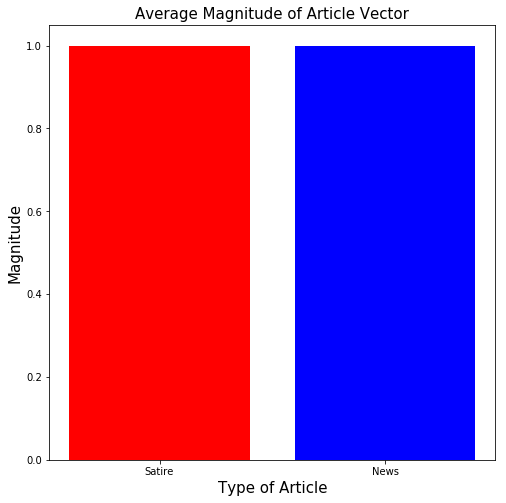

In [176]:
fig, ax = plt.subplots(figsize= (8,8))
plt.bar(['Satire', 'News'],[Satire_mag, News_mag], color ='rby')
ax.set_title("Average Magnitude of Article Vector", fontsize = 15)
ax.set_ylabel("Magnitude", fontsize = 15)
ax.set_xlabel("Type of Article", fontsize = 15)

### SVD

In [47]:
u, s, vt = svds(X_train)

In [48]:
u.shape

(10665, 6)

### Sample Trump Article

In [386]:
sample = 'WASHINGTON—Following the announcement that Homeland Security Secretary Kirstjen Nielsen was leaving her post, President Trump told reporters Monday he would conduct an extensive search to find a replacement with the right personality disorders necessary for the role. “Though I admired Kirstjen’s ability to remain cold and detached when questioned about the decision to tear apart families at the border, we require someone with an even greater lack of empathy to do this job properly,” said the president, who praised Nielsen for putting children in cages but explained that the ideal candidate for the position must possess a degree of psychopathy so severe that they believe no law or moral code of any kind applies to them. “The next person to head the department must be blessed with strong narcissistic tendencies, of course, but also a consistent record of profoundly antisocial behavior. We need someone both spiteful and cruel, but also willing to totally disregard right and wrong. Basically, the new secretary will need to have a psychological makeup that allows them to look people in the eye and tell them, without hesitation, that we don’t want any non-Americans entering the United States unless they’re coming from one of a very limited group of countries in northern Europe.” At press time, a team of psychiatrists had reportedly presented the president with a stack of résumés that consisted solely of individuals housed in supermax prisons and White House senior adviser Stephen Miller.'

In [387]:
len(sample.split())

240

In [388]:
def new_cleaner(article_list):
    '''
    Removes more features like punctuation and words that
    should not be in there
    Input: df_final
    output: df_final with cleaned articles
    '''
    #article_list = list(df_final.Article)
    clean_list = []
    #for article in article_list:
    #samp1 = re.sub('[''\”\“\‘;:\'\'\'•·%$!&+}{|><_…/\’*0123456789\`]', '', article_list)
    samp1 = re.sub(r'\W+', ' ', article_list)
    samp2 = re.sub('[-—]', ' ', samp1)
    samp3 = samp2.replace('news','')
    clean_list.append(samp3.replace('fox',''))
    #df['Article'] = clean_list
    return clean_list

In [389]:
clean_sample = new_cleaner(sample)

In [390]:
clean_sample

['WASHINGTON Following the announcement that Homeland Security Secretary Kirstjen Nielsen was leaving her post President Trump told reporters Monday he would conduct an extensive search to find a replacement with the right personality disorders necessary for the role Though I admired Kirstjen s ability to remain cold and detached when questioned about the decision to tear apart families at the border we require someone with an even greater lack of empathy to do this job properly said the president who praised Nielsen for putting children in cages but explained that the ideal candidate for the position must possess a degree of psychopathy so severe that they believe no law or moral code of any kind applies to them The next person to head the department must be blessed with strong narcissistic tendencies of course but also a consistent record of profoundly antisocial behavior We need someone both spiteful and cruel but also willing to totally disregard right and wrong Basically the new s

In [345]:
vect_sample = vect.transform(clean_sample)

In [346]:
vect_sample

<1x19822 sparse matrix of type '<class 'numpy.float64'>'
	with 108 stored elements in Compressed Sparse Row format>

In [347]:
row_idx, col_idx, val = find(vect_sample)

In [348]:
col_idx

array([   50,   249,   496,   571,   696,   760,   803,  1541,  1567,
        1840,  2008,  2478,  2562,  3036,  3344,  3376,  3435,  3569,
        3648,  3869,  3879,  4051,  4374,  4549,  4628,  4881,  4909,
        5039,  5548,  5651,  5830,  5959,  5985,  6017,  6107,  6560,
        7389,  7482,  7857,  8020,  8166,  8269,  8448,  8681,  9249,
        9584,  9768,  9920,  9971, 10173, 10317, 10570, 11212, 11435,
       11493, 11762, 11841, 11849, 11914, 11968, 12043, 12093, 13028,
       13083, 13497, 13501, 13503, 13552, 13635, 13637, 13641, 13699,
       13742, 13781, 13859, 14017, 14337, 14518, 14587, 14588, 14616,
       14820, 14936, 15129, 15538, 15563, 15571, 15637, 15711, 16323,
       16527, 16692, 16766, 16912, 17438, 17442, 17478, 17499, 17608,
       17728, 17794, 17861, 18481, 18494, 19136, 19176, 19347, 19599],
      dtype=int32)

In [349]:
zipper = list(zip(list(row_idx),(col_idx)))

In [350]:
zipper

[(0, 50),
 (0, 249),
 (0, 496),
 (0, 571),
 (0, 696),
 (0, 760),
 (0, 803),
 (0, 1541),
 (0, 1567),
 (0, 1840),
 (0, 2008),
 (0, 2478),
 (0, 2562),
 (0, 3036),
 (0, 3344),
 (0, 3376),
 (0, 3435),
 (0, 3569),
 (0, 3648),
 (0, 3869),
 (0, 3879),
 (0, 4051),
 (0, 4374),
 (0, 4549),
 (0, 4628),
 (0, 4881),
 (0, 4909),
 (0, 5039),
 (0, 5548),
 (0, 5651),
 (0, 5830),
 (0, 5959),
 (0, 5985),
 (0, 6017),
 (0, 6107),
 (0, 6560),
 (0, 7389),
 (0, 7482),
 (0, 7857),
 (0, 8020),
 (0, 8166),
 (0, 8269),
 (0, 8448),
 (0, 8681),
 (0, 9249),
 (0, 9584),
 (0, 9768),
 (0, 9920),
 (0, 9971),
 (0, 10173),
 (0, 10317),
 (0, 10570),
 (0, 11212),
 (0, 11435),
 (0, 11493),
 (0, 11762),
 (0, 11841),
 (0, 11849),
 (0, 11914),
 (0, 11968),
 (0, 12043),
 (0, 12093),
 (0, 13028),
 (0, 13083),
 (0, 13497),
 (0, 13501),
 (0, 13503),
 (0, 13552),
 (0, 13635),
 (0, 13637),
 (0, 13641),
 (0, 13699),
 (0, 13742),
 (0, 13781),
 (0, 13859),
 (0, 14017),
 (0, 14337),
 (0, 14518),
 (0, 14587),
 (0, 14588),
 (0, 14616),
 (0,

In [351]:
probas_word_removal = []
for idx in zipper:
    vect_sample = vect.transform(clean_sample)
    print(vect_sample[0,50])
    print(vect_sample[idx])
    vect_sample[idx] = 0
    print(vect_sample[idx])
    prb = log_reg.predict_proba(vect_sample)
    sat_prob = prb[0][1]
    probas_word_removal.append(sat_prob)

0.08740357239347145
0.08740357239347145
0.0
0.08740357239347145
0.07416360026558053
0.0
0.08740357239347145
0.06411492800004227
0.0
0.08740357239347145
0.04987381878445397
0.0
0.08740357239347145
0.06003941365369697
0.0
0.08740357239347145
0.09001187277967314
0.0
0.08740357239347145
0.09367688847801896
0.0
0.08740357239347145
0.09087097335967502
0.0
0.08740357239347145
0.057101278280654574
0.0
0.08740357239347145
0.11778202063460044
0.0
0.08740357239347145
0.0833419204612265
0.0
0.08740357239347145
0.14093139355985948
0.0
0.08740357239347145
0.06567690972705474
0.0
0.08740357239347145
0.06850937665885494
0.0
0.08740357239347145
0.11035000779846783
0.0
0.08740357239347145
0.10534558322139329
0.0
0.08740357239347145
0.04654158284702583
0.0
0.08740357239347145
0.07666631335125244
0.0
0.08740357239347145
0.09332703593249927
0.0
0.08740357239347145
0.05056814622788253
0.0
0.08740357239347145
0.07520411049412733
0.0
0.08740357239347145
0.13335252851083393
0.0
0.08740357239347145
0.0654085327

In [352]:
probas_word_removal 

[0.7804043341840825,
 0.7999073673691323,
 0.789561104087036,
 0.7634884567368034,
 0.7701320528765689,
 0.7813151064617821,
 0.7864237796310504,
 0.780840140723719,
 0.7927176152819532,
 0.7861652268670609,
 0.7986722870589049,
 0.781722762807171,
 0.7800981129297452,
 0.7939160792195539,
 0.7890290014912891,
 0.7827902554929766,
 0.7897257196970302,
 0.7953764330435166,
 0.7847173128589159,
 0.7914583354948879,
 0.7806643801342096,
 0.7773528580158996,
 0.7868032999203917,
 0.8039556721870593,
 0.7848988655796262,
 0.7864948720053623,
 0.7807777916306461,
 0.7891381857333187,
 0.7861148557307064,
 0.7884260301144819,
 0.8008843743787386,
 0.752504453941672,
 0.7821003623162212,
 0.7585002353866761,
 0.7980617835131006,
 0.7904781530242677,
 0.7825360850210459,
 0.8025134587317032,
 0.7811138499118252,
 0.7807190469019475,
 0.7903843453437553,
 0.8190239831670683,
 0.7739402783166998,
 0.7716029223850764,
 0.784363713145623,
 0.7769699724379221,
 0.7847668260078535,
 0.799423697175589

In [371]:
min(probas_word_removal), max(probas_word_removal)

(0.6914787015382483, 0.8190239831670683)

In [184]:
feat_array[col_idx]

array(['abil', 'advis', 'allow', 'american', 'announc', 'antisoci',
       'apart', 'appli', 'behavior', 'believ', 'bless', 'border', 'cage',
       'candid', 'children', 'code', 'cold', 'come', 'conduct', 'consist',
       'countri', 'cours', 'cruel', 'decis', 'depart', 'detach', 'disord',
       'disregard', 'dont', 'empathi', 'enter', 'europ', 'explain',
       'extens', 'eye', 'famili', 'follow', 'greater', 'group', 'head',
       'hesit', 'homeland', 'hous', 'ideal', 'individu', 'job', 'kind',
       'lack', 'law', 'leav', 'limit', 'look', 'makeup', 'miller',
       'monday', 'moral', 'narcissist', 'necessari', 'need', 'new',
       'nielsen', 'non', 'northern', 'peopl', 'person', 'posit',
       'possess', 'post', 'prais', 'present', 'presid', 'press', 'prison',
       'profoundli', 'properli', 'psychiatrist', 'put', 'question',
       'record', 'remain', 'report', 'reportedli', 'requir', 'right',
       'role', 'résumé', 'search', 'secretari', 'secur', 'senior',
       'sever', 

In [140]:
val

array([0.08208164, 0.07125403, 0.06146756, 0.04740855, 0.05674347,
       0.18074718, 0.08645114, 0.08874189, 0.08689918, 0.05470175,
       0.11175435, 0.07889035, 0.13606684, 0.0622461 , 0.06578656,
       0.10391194, 0.09953767, 0.04465804, 0.07305734, 0.08874189,
       0.0482787 , 0.07120744, 0.1267223 , 0.06288494, 0.0559591 ,
       0.13977433, 0.11982927, 0.12343534, 0.05618014, 0.14046372,
       0.07448216, 0.08874189, 0.0664201 , 0.09457351, 0.07298104,
       0.05423191, 0.05211468, 0.09516945, 0.05474313, 0.06014257,
       0.11957666, 0.09151242, 0.09534018, 0.10278193, 0.0695762 ,
       0.06427577, 0.06654921, 0.08134069, 0.05675489, 0.06215645,
       0.07885643, 0.04853649, 0.13550969, 0.10918907, 0.05323689,
       0.1071826 , 0.15840701, 0.08577325, 0.0996073 , 0.04067395,
       0.324229  , 0.12979757, 0.09144937, 0.03835443, 0.11049257,
       0.06517217, 0.09617672, 0.06142437, 0.08484243, 0.07640116,
       0.08223878, 0.04400652, 0.0853958 , 0.13846195, 0.10801

### Test for half of a CNN article

In [79]:
#cnn_test ='Attorney General William Barr said Tuesday he expects to release a redacted version of special counsel Robert Muellers nearly report within a week, but he does not plan to provide Congress with an unredacted version of the report, setting the stage for a showdown with congressional Democrats.Barr told a House subcommittee Tuesday that the redactions process was going very well, and he would explain the rationale for the that are made from Muellers nearly 400-page report.'

In [383]:
cnn_test ='Attorney General William Barr said Tuesday he expects to release a redacted version of special counsel Robert Muellers nearly report "within a week," but he does not plan to provide Congress with an unredacted version of the report, setting the stage for a showdown with congressional Democrats.Barr told a House subcommittee Tuesday that the redactions process was going "very well," and he would explain the rationale for the that are made from Muellers nearly 400-page report. But he said he would not accede to Democrats demands that he provide the full, unredacted report to Congress, arguing that he cannot legally release grand jury material and that he did not plan to ask a court to release it. "I dont intend at this stage to send the full, unredacted report to the committee," Barr said.Barrs comments Tuesday come ahead of a brewing clash between Congress and the Trump administration over the Mueller report, as Democrats are indeed prepared to go to court in an effort to obtain the unredacted Mueller report and the special counsels underlying evidence. Democrats on the House Judiciary Committee have already authorized a subpoena for the full Mueller report and the underlying evidence, which House Judiciary Chairman Jerry Nadler said Tuesday he is waiting to see what Barr releases before moving forward on the subpoena. "The question is what we receive -- do we receive a full copy of the Mueller Report and the documentation underneath it?" Nadler said. "Do we receive most of it with a little redaction or do they completely expurgate it? Well have to take a look at it." Asked Tuesday about the grand jury material, Barr told a House Appropriations subcommittee: "The chairman of the Judiciary Committee is free to go to court." Four types of information would be redacted from the report he submits, Barr said, including grand jury material, classified information, material tied to ongoing investigation, and information that could harm "peripheral third parties."'

In [353]:
cnn_test2 = 'report to the committee," Barr said.Barrs comments Tuesday come ahead of a brewing clash between Congress and the Trump administration over the Mueller report, as Democrats are indeed prepared to go to court in an effort to obtain the unredacted Mueller report and the special counsels underlying evidence. Democrats on the House Judiciary Committee have already authorized a subpoena for the full Mueller report and the underlying evidence, which House Judiciary Chairman Jerry Nadler said Tuesday he is waiting to see what Barr releases before moving forward on the subpoena. "The question is what we receive -- do we receive a full copy of the Mueller Report and the documentation underneath it?" Nadler said. "Do we receive most of it with a little redaction or do they completely expurgate it? Well have to take a look at it." Asked Tuesday about the grand jury material, Barr told a House Appropriations subcommittee: "The chairman of the Judiciary Committee is free to go to court." Four types of information would be redacted from the report he submits, Barr said, including grand jury material, classified information, material tied to ongoing investigation, and information that could harm "peripheral third parties."'

In [396]:
regex_samp = re.sub(r'\W+', ' ', cnn_test)
regex_samp2 = re.sub('[0123456789]', '', regex_samp)
regex_samp2

'Attorney General William Barr said Tuesday he expects to release a redacted version of special counsel Robert Muellers nearly report within a week but he does not plan to provide Congress with an unredacted version of the report setting the stage for a showdown with congressional Democrats Barr told a House subcommittee Tuesday that the redactions process was going very well and he would explain the rationale for the that are made from Muellers nearly  page report But he said he would not accede to Democrats demands that he provide the full unredacted report to Congress arguing that he cannot legally release grand jury material and that he did not plan to ask a court to release it I dont intend at this stage to send the full unredacted report to the committee Barr said Barrs comments Tuesday come ahead of a brewing clash between Congress and the Trump administration over the Mueller report as Democrats are indeed prepared to go to court in an effort to obtain the unredacted Mueller re

In [354]:
len(cnn_test2.split())

196

In [355]:
cnn_clean_sample = new_cleaner(cnn_test2)


In [356]:
cnn_vect_sample = vect.transform(cnn_clean_sample)

In [360]:
cnn_row, cnn_col, cnn_val = find(cnn_vect_sample)

In [357]:
log_reg.predict_proba(cnn_vect_sample)

array([[0.6870812, 0.3129188]])

In [358]:
log_reg.predict(cnn_vect_sample)

array([0])

In [369]:
feat_array

array(["''", '``', 'aa', ..., 'zurich', 'zuzu', 'zverev'], dtype='<U18')

In [370]:
feat_array[cnn_col]

array(['``', 'administ', 'ahead', 'applebe', 'ashcroft', 'aura', 'barn',
       'chant', 'clemenc', 'commonsens', 'compassion', 'competitor',
       'conced', 'consensu', 'corner', 'courier', 'coyot', 'denni', 'dom',
       'eggleston', 'exactli', 'fowl', 'freez', 'grand', 'hardlin',
       'household', 'inflam', 'invalid', 'jenkin', 'juana', 'junctur',
       'maxim', 'multilingu', 'namesak', 'odiou', 'opportunist', 'past',
       'perth', 'presumptu', 'quot', 'recommend', 'reduct', 'remand',
       'reput', 'saliv', 'sped', 'su', 'submarin', 'submit', 'thyroid',
       'today', 'tub', 'twist', 'undergon', 'underhand', 'unqualifi',
       'wadi'], dtype='<U18')